# COVID-19 Mental Health Mapping

### Install Packages

In [1]:
#!pip install nltk
#!pip install pandas_profiling
#!pip install wordcloud
#!pip install opencv-python

### Import Libraries

In [26]:
#Data Analysis
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import seaborn as sns
import pandas_profiling
from collections import Counter
import cv2
import datetime
format="%Y-%m-%d"
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2

#NLP
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(['I', "I'm",'im', 'st', 'r', 'guys','hey','hello', 'hi'])

import re
from wordcloud import WordCloud, ImageColorGenerator
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nunnn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nunnn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Reddit Analysis 

Reddit data is used for directional analysis into the types of mental health issues people are most likely to face during COVID-19. Reddit focuses on anonymous user conversations, and as a result is useful for capturing genuine discussions around mental health which may be missing in Twitter data due to the non-anonymized nature of the platform. 

Reddit may also be used as a training source in order to build a supervised learning model that classifies posts into mental health indications from Twitter.
Posts are sourced from subreddits dedicated to conversations around mental health issues (r/COVID19_support, r/depression, r/anxiety, r/HealthAnxiety, r/bipolar, r/schizophrenia). 

In [3]:
#Load corpus of Reddit posts. 
#Dates: Jan 1 2020 - Sept 30 2021
os.chdir('C:\\Users\\nunnn\\Downloads')
reddit_df = pd.read_csv('reddit_corpus.csv')
reddit_df = pd.DataFrame(reddit_df)
reddit_df = reddit_df[reddit_df['Subreddit'].notna()]
reddit_df

,Query Id,Query Name,Subreddit,Date,Title,Snippet
0,2.000748e+09,Mental Health,r/Anxiety,5/8/2020,Always need a deep breathe!,...Later on I heard another woman describing a...
1,2.000748e+09,Mental Health,r/Anxiety,4/21/2020,Let's post good news on the coronavirus here.,Agreed! I do like a nice latte once in a while...
2,2.000748e+09,Mental Health,r/Anxiety,8/20/2020,Does anyone else experience back to work anxiety,Only when I hated my job (when I was in retail...
3,2.000748e+09,Mental Health,r/Anxiety,5/26/2020,I cant walk through a town or even a village o...,Does your mom keep you updated on the news on ...
4,2.000748e+09,Mental Health,r/Anxiety,8/23/2021,Just took my medication for the first time,I remember the lead up to beginning meds (I’m ...
...,...,...,...,...,...,...
18402,2.000748e+09,Mental Health,r/schizophrenia,5/5/2020,Does ADHD medication affect your paranoia?,According to the internet: Unlike other drugs ...
18403,2.000748e+09,Mental Health,r/schizophrenia,2/4/2020,What is your experience with having psychosis ...,I am diagnosed with schizoaffective disorder (...
18404,2.000748e+09,Mental Health,r/schizophrenia,1/15/2021,How should closed ones react?,Like I said I’m prospering with no medication ...
18405,2.000748e+09,Mental Health,r/schizophrenia,4/13/2021,Schizophrenia and aphantasia ?,no i never understood what my teachers meant i...


In [4]:
#Total subreddit post volumes
Counter(reddit_df['Subreddit'])

Counter({'r/Anxiety': 5000,
         'r/bipolar': 5000,
         'r/Depression': 4419,
         'r/schizophrenia': 3988})

In [5]:
#Convert Date values to datetime64 

reddit_df['Date'] = pd.to_datetime(reddit_df['Date'], format = "%m/%d/%Y")

#Analyze only posts from Jan 2020 - Sept 2021 (drop Oct 2021 posts)
reddit_df = reddit_df[(reddit_df['Date'] < '10/1/2021')]

reddit_df

,Query Id,Query Name,Subreddit,Date,Title,Snippet
0,2.000748e+09,Mental Health,r/Anxiety,2020-05-08,Always need a deep breathe!,...Later on I heard another woman describing a...
1,2.000748e+09,Mental Health,r/Anxiety,2020-04-21,Let's post good news on the coronavirus here.,Agreed! I do like a nice latte once in a while...
2,2.000748e+09,Mental Health,r/Anxiety,2020-08-20,Does anyone else experience back to work anxiety,Only when I hated my job (when I was in retail...
3,2.000748e+09,Mental Health,r/Anxiety,2020-05-26,I cant walk through a town or even a village o...,Does your mom keep you updated on the news on ...
4,2.000748e+09,Mental Health,r/Anxiety,2021-08-23,Just took my medication for the first time,I remember the lead up to beginning meds (I’m ...
...,...,...,...,...,...,...
18402,2.000748e+09,Mental Health,r/schizophrenia,2020-05-05,Does ADHD medication affect your paranoia?,According to the internet: Unlike other drugs ...
18403,2.000748e+09,Mental Health,r/schizophrenia,2020-02-04,What is your experience with having psychosis ...,I am diagnosed with schizoaffective disorder (...
18404,2.000748e+09,Mental Health,r/schizophrenia,2021-01-15,How should closed ones react?,Like I said I’m prospering with no medication ...
18405,2.000748e+09,Mental Health,r/schizophrenia,2021-04-13,Schizophrenia and aphantasia ?,no i never understood what my teachers meant i...


In [6]:
#Reddit posts are extracted with the post Title and the "Snippet", which may be a further explanation of the post or a response by another user to the post. To avoid artifically inflating terms, we limit each 
# post to appearing only once in the dataset by removing duplicate "Title" values.

reddit_df = reddit_df.drop_duplicates(subset=['Title'])

#In order to capture the maximum amount of contextual conversation possible, we concatenate both columns to produce one column with all words in both the post title and reply/snippet.
content = []
for i in reddit_df.index:
    content.append(str(reddit_df['Title'][i]) + " " + str(reddit_df['Snippet'][i]))

reddit_df['content'] = content

<ipython-input-6-273ef264431d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df['content'] = content


## Exploratory Data Analysis

Distribution of posts by Mental Health category

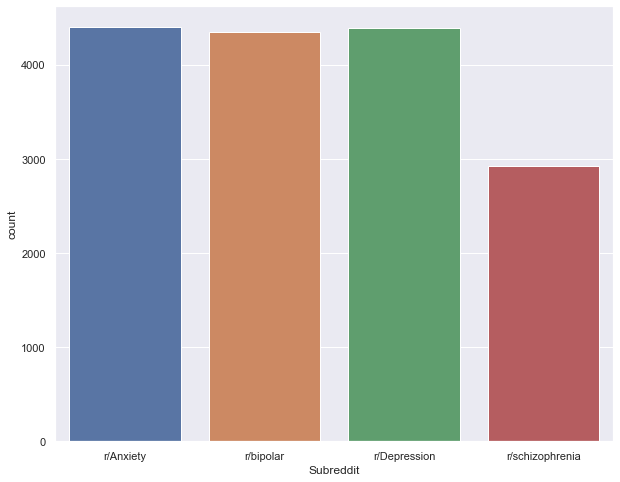

In [7]:
sns.set(style='darkgrid')
plt.figure(figsize=(10,8))
ax = sns.countplot(x='Subreddit', data=reddit_df)
plt.savefig('counts.png')

Distribution of post lengths within each mental health category

<ipython-input-8-958a7d011bc4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df['post_length'] = reddit_df['content'].str.len()


count    16053.000000
mean       303.581137
std        121.849820
min         16.000000
25%        201.000000
50%        359.000000
75%        393.000000
max        660.000000
Name: post_length, dtype: float64

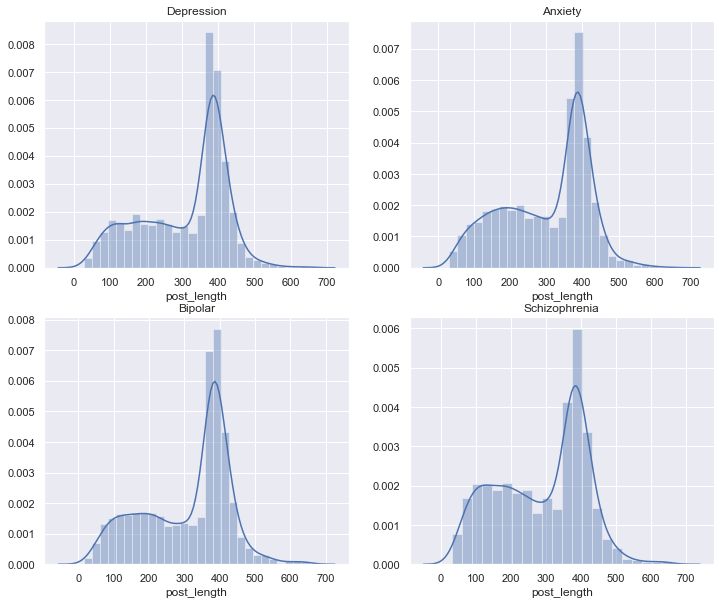

In [8]:
reddit_df['post_length'] = reddit_df['content'].str.len()


fig = plt.figure(figsize=(12,10))

rows=2
columns = 2

fig.add_subplot(rows, columns, 1)
sns.distplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/Depression'])
#plt.axis('off')
plt.title('Depression')

fig.add_subplot(rows, columns, 2)
sns.distplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/Anxiety'])
#plt.axis('off')
plt.title('Anxiety')

fig.add_subplot(rows, columns, 3)
sns.distplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/bipolar'])
#plt.axis('off')
plt.title('Bipolar')

fig.add_subplot(rows, columns, 4)
sns.distplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/schizophrenia'])
#plt.axis('off')
plt.title('Schizophrenia')



plt.savefig('post_length.png')
reddit_df['post_length'].describe()

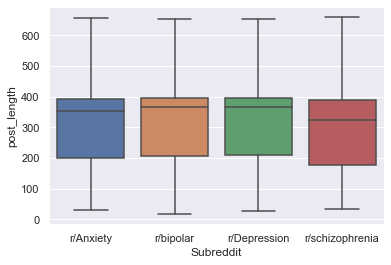

In [9]:
sns.boxplot(data=reddit_df, x='Subreddit', y='post_length')
plt.savefig('post_length_boxplot.png')

In [10]:
#profile = pandas_profiling.ProfileReport(reddit_df)
#profile.to_file(output_file = 'reddit_df.html')

## Predictive Model for Text Classification

## Text Preprocessing

The first step in creating a text classification model is to run the necessary preprocessing on all posts

In [11]:
#Data Cleaning
#Reddit posts are storied as a list of string values. To process each string value in the list, iterate the function over each string item in the list.

lowercase_posts = []
for i in reddit_df.index:
    lowercase_posts.append(reddit_df['content'][i].lower())

reddit_df['content'] = lowercase_posts

#Remove punctuation from posts
strip_punctuation = []
for i in reddit_df.index:
    strip_punctuation.append(reddit_df['content'][i].translate(str.maketrans('','',string.punctuation)))

reddit_df['content'] = strip_punctuation

#Tokenize each string input to generate list of lists containing string values
tokenized_posts = []
for i in reddit_df.index:
    tokenized_posts.append(word_tokenize(reddit_df['content'][i]))

reddit_df['content'] = tokenized_posts

#Remove stopwords
stop_words = set(stopwords.words('english'))

filtered_posts = []
for i in reddit_df.index:
    filtered_posts.append([w for w in reddit_df['content'][i] if w not in stop_words])

reddit_df['content'] = filtered_posts

<ipython-input-11-45561dcf0fb3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df['content'] = lowercase_posts
<ipython-input-11-45561dcf0fb3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df['content'] = strip_punctuation
<ipython-input-11-45561dcf0fb3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Next, we need to assign numeric values to our mental health categories as part of our feature engineering process. This is done by creating a dictionary of key value pairs.

In [12]:
topic_codes = {'r/Depression' : 0,
                      'r/Anxiety' : 1,
                      'r/bipolar' : 2,
                      'r/schizophrenia' : 3}

reddit_df['topic_code'] = reddit_df['Subreddit']
reddit_df = reddit_df.replace({'topic_code':topic_codes})

reddit_df.head()

<ipython-input-12-2e4258153ae1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df['topic_code'] = reddit_df['Subreddit']


,Query Id,Query Name,Subreddit,Date,Title,Snippet,content,post_length,topic_code
0,2.000748e+09,Mental Health,r/Anxiety,2020-05-08,Always need a deep breathe!,...Later on I heard another woman describing a...,"[always, need, deep, breathe, later, heard, an...",381,1
1,2.000748e+09,Mental Health,r/Anxiety,2020-04-21,Let's post good news on the coronavirus here.,Agreed! I do like a nice latte once in a while...,"[lets, post, good, news, coronavirus, agreed, ...",204,1
2,2.000748e+09,Mental Health,r/Anxiety,2020-08-20,Does anyone else experience back to work anxiety,Only when I hated my job (when I was in retail...,"[anyone, else, experience, back, work, anxiety...",113,1
3,2.000748e+09,Mental Health,r/Anxiety,2020-05-26,I cant walk through a town or even a village o...,Does your mom keep you updated on the news on ...,"[cant, walk, town, even, village, without, mum...",542,1
4,2.000748e+09,Mental Health,r/Anxiety,2021-08-23,Just took my medication for the first time,I remember the lead up to beginning meds (I’m ...,"[took, medication, first, time, remember, lead...",394,1


## Train Test Split

The data is split into a training set (80% of records) and a test set (20% of records)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(reddit_df['content'], reddit_df['topic_code'], test_size = 0.20, random_state=1)


Here we set the parameters for TF-IDF vectorization.

Paramters:

ngram_range: The upper and lower boundary of the range of n-values for different n-grams to be extracted. n-grams are continuous sequences of characters that appear sequentally. 
Setting ngram_range to (1,1) instructs the algorithm to extract only single words (unigrams). This can also be set to both unigrams and bigrams (1,2), or only bigrams (2,2).

min_df = This instructs the algorithm to ignore terms which have a document frequency lower than the given threshold. Document Frequency is the number of documents (posts) containing
a particular term.

min_df = This instructs the algorithm to ignore terms which have a document frequency higher than the given threshold.

In [35]:
ngram_range = (1,1)
min_df = 0.01
max_df = 1.0
max_features = 300
stop_words = stop_words


In [38]:
tfidf = TfidfVectorizer(encoding = 'utf-8', 
                       ngram_range = ngram_range,
                       min_df = min_df,
                       max_df = max_df,
                       lowercase=False, 
                       max_features = max_features,
                       stop_words = stop_words, 
                       norm = 'l2', 
                       sublinear_tf = True)

features_train = tfidf.fit_transform(x_train).toarray()
labels_train = y_train
print(features_train.shape)

TypeError: expected string or bytes-like object

## Topic Analysis within Mental Health indications

Text(0.5, 1.0, 'Bipolar')

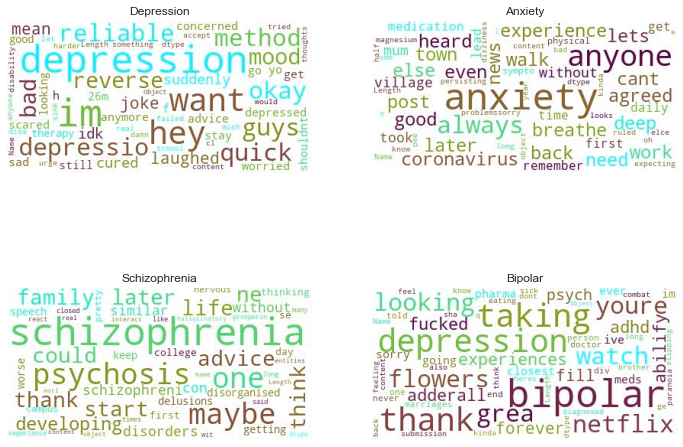

In [13]:
#Generate wordclouds for each subreddit and save the output to an image file
overall_wc = WordCloud(stopwords = stop_words, max_font_size=50, max_words=100, background_color="white").generate(str(reddit_df['content']))
overall_wc.to_file('overall.jpg')

depression_wc = WordCloud(stopwords = stop_words, max_font_size=50, max_words=100, background_color="white").generate(str(reddit_df['content'][reddit_df.Subreddit.eq('r/Depression')]))
depression_wc.to_file('depression.jpg')

anxiety_wc = WordCloud(stopwords = stop_words, max_font_size=50, max_words=100, background_color="white").generate(str(reddit_df['content'][reddit_df.Subreddit.eq('r/Anxiety')]))
anxiety_wc.to_file('anxiety.jpg')


schizophrenia_wc = WordCloud(stopwords = stop_words, max_font_size=50, max_words=100, background_color="white").generate(str(reddit_df['content'][reddit_df.Subreddit.eq('r/schizophrenia')]))
schizophrenia_wc.to_file('schizophrenia.jpg')

bipolar_wc = WordCloud(stopwords = stop_words, max_font_size=50, max_words=100, background_color="white").generate(str(reddit_df['content'][reddit_df.Subreddit.eq('r/bipolar')]))
bipolar_wc.to_file('bipolar.jpg')


#Set up figure
fig = plt.figure(figsize=(12,9))

rows=2
columns = 2

#Read images and add to figure
fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.imread('depression.jpg'))
plt.axis('off')
plt.title('Depression')

fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.imread('anxiety.jpg'))
plt.axis('off')
plt.title('Anxiety')


fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.imread('schizophrenia.jpg'))
plt.axis('off')
plt.title('Schizophrenia')

fig.add_subplot(rows, columns, 4)
plt.imshow(cv2.imread('bipolar.jpg'))
plt.axis('off')
plt.title('Bipolar')


Through Reddit we have a large volume of posts that are "labelled" according to conversation topics. All posts within each subreddit can be labelled according to the indication the subreddit is dedicated to. We can use this data to train a classification model, which will be used to organize social media posts into various mental health conditions.

In [14]:
#What proportion of posts about mental health are related to COVID-19 and/or it's associated restrictions?
covid_keywords = ['COVID','pandemic','lockdown','shutdown','coronavirus','restriction']

## Twitter Analysis

Using the classification model trained on Reddit forum conversations related to mental health, we can categorize Tweets into various mental health indications. The key value proposition of using Twitter data is that it also includes user information, including the location of the author. We can use this information to assess changes in mental health conversation volumes regionally, and in response to COVID-19 changes in various provinces.

In [15]:
twitter_df = pd.read_csv('twitter_corpus.csv', encoding = 'unicode_escape')
twitter_df = pd.DataFrame(twitter_df)

#Drop N/A values, and include only posts which have an identified geographic region

twitter_df = twitter_df[twitter_df['Snippet'].notna()]
twitter_df = twitter_df[twitter_df['Region'].notna()]
twitter_df

,Query Id,Query Name,Date,Title,Snippet,Country,Region,City Code,Location Name
0,2.000748e+09,Mental Health,9/17/2021,"@tarastrong Also, some could say thatâs schi...","@tarastrong Also, some could say thatâs schi...",Canada,Ontario,NaN,"ON, CAN"
1,2.000748e+09,Mental Health,8/18/2021,@MatthewKBegbie âA man ð¨ goes to doctor ð...,@MatthewKBegbie âA man ð¨ goes to doctor ð...,Canada,Ontario,CAN.ON.Toronto,"Toronto, ON, CAN"
2,2.000748e+09,Mental Health,8/10/2020,@cora_corgi as in.. whenever someone with adhd...,@cora_corgi as in.. whenever someone with adhd...,Canada,Alberta,NaN,"AB, CAN"
3,2.000748e+09,Mental Health,5/14/2021,Anxiety is the worst ð£,Anxiety is the worst ð£,Canada,Ontario,CAN.ON.Toronto,"Toronto, ON, CAN"
4,2.000748e+09,Mental Health,1/14/2020,CAN XICHENG STANS STOP DEPRESSING ME WITH EVER...,CAN XICHENG STANS STOP DEPRESSING ME WITH EVER...,Canada,Ontario,CAN.ON.Toronto,"Toronto, ON, CAN"
...,...,...,...,...,...,...,...,...,...
7580,2.000748e+09,Mental Health,3/11/2020,@7107Lilly @jcstaff_ More twitter edits needed...,@7107Lilly @jcstaff_ More twitter edits needed...,Canada,British Columbia,CAN.BC.Vancouver,"Vancouver, BC, CAN"
7582,2.000748e+09,Mental Health,2/10/2021,@_techniker my â¨depression â¨ will also not...,@_techniker my â¨depression â¨ will also not...,Canada,Ontario,NaN,"ON, CAN"
7583,2.000748e+09,Mental Health,5/25/2021,My depression was so acute I tried to resign. ...,My depression was so acute I tried to resign. ...,Canada,Ontario,CAN.ON.Toronto,"Toronto, ON, CAN"
7584,2.000748e+09,Mental Health,10/1/2020,@Darkhorseequus Holy shit itâs EVERYONE toda...,@Darkhorseequus Holy shit itâs EVERYONE toda...,Canada,Ontario,NaN,"ON, CAN"


## Future Directions: Time Series Analysis

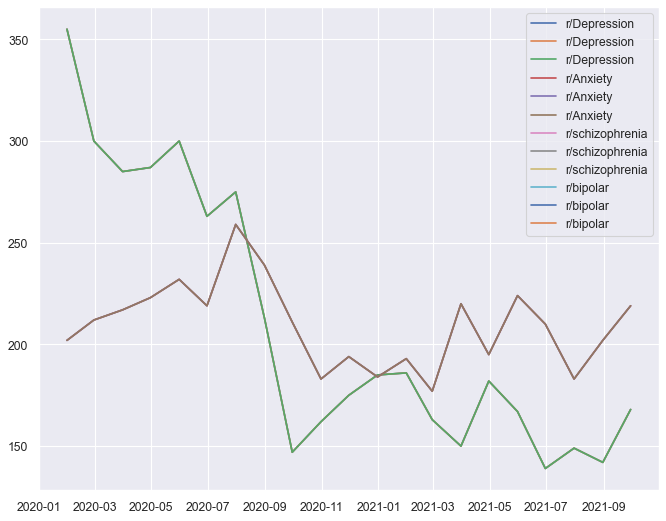

In [16]:
#Generate separate dataframes for each indication
depression_df = reddit_df[reddit_df['Subreddit'] == 'r/Depression']
anxiety_df = reddit_df[reddit_df['Subreddit'] == 'r/Anxiety']
schizophrenia_df = reddit_df[reddit_df['Subreddit'] == 'r/Schizophrenia']
bipolar_df = reddit_df[reddit_df['Subreddit'] == 'r/Bipolar']


#Define function for generating post volume counts by month for each indication

def postvolume(x):
        num_posts = x.groupby(pd.Grouper(key='Date', freq='M')).count()
        num_posts = pd.DataFrame(num_posts)
        num_posts = num_posts.drop(['Query Id','Query Name','Subreddit','Title','Snippet'],axis=1)
        num_posts = num_posts.rename(columns={'content':'Posts'})
        return num_posts
    


#Run function on each indication to generate post volumes over time
depression_volume = postvolume(depression_df)
anxiety_volume = postvolume(anxiety_df)
schizophrenia_volume = postvolume(schizophrenia_df)
bipolar_volume = postvolume(bipolar_df)
    

    
#Plot activity over time for each subreddit

from matplotlib.pyplot import figure
figure(figsize=(10,8), dpi=80)
plt.plot(depression_volume, label='r/Depression')
plt.plot(anxiety_volume, label = 'r/Anxiety')
plt.plot(schizophrenia_volume, label = 'r/schizophrenia')
plt.plot(bipolar_volume, label = 'r/bipolar')
plt.legend(loc='upper right')